<h1>CADRL Complete Training (IL + RL)</h1>

Import the necessary packages

In [1]:
from jax import random, device_get
import jax.numpy as jnp
import optax
import numpy as np
import time
import matplotlib.pyplot as plt

from socialjym.envs.socialnav import SocialNav
from socialjym.policies.cadrl import CADRL
from socialjym.utils.replay_buffers.uniform_vnet_replay_buffer import UniformVNetReplayBuffer
from socialjym.utils.rollouts.deep_vnet_rollouts import deep_vnet_rl_rollout, deep_vnet_il_rollout
from socialjym.utils.aux_functions import epsilon_scaling_decay, plot_state, plot_trajectory, test_k_trials
from socialjym.utils.rewards.reward1 import generate_reward_done_function

/home/tommaso/PyVenvs/socialjym/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the training hyperparameters

In [2]:
random_seed = 1
il_training_episodes = 3_000
il_learning_rate = 0.01
il_num_epochs = 50 # Number of epochs to train the model after ending IL
rl_training_episodes = 20_000
rl_learning_rate = 0.001
rl_num_batches = 100 # Number of batches to train the model after each RL episode
batch_size = 100 # Number of experiences to sample from the replay buffer for each model update
epsilon_start = 0.5
epsilon_end = 0.1
epsilon_decay = 4_000
buffer_size = 100_000 # Maximum number of experiences to store in the replay buffer (after exceeding this limit, the oldest experiences are overwritten with new ones)
target_update_interval = 50 # Number of episodes to wait before updating the target network for RL (the one used to compute the target state values)

Set the reward and environment parameters

In [3]:
# Reward function parameters
reward_params = {
    'goal_reward': 1.,
    'collision_penalty': 0.25,
    'discomfort_distance': 0.2,
    'time_limit': 50.,
}

# Initialize reward function
reward_function = generate_reward_done_function(**reward_params)

# Environment parameters
env_params = {
    'robot_radius': 0.3,
    'n_humans': 1,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': False,
    'scenario': 'circular_crossing',
    'humans_policy': 'hsfm',
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}

Initialize environment, robot policy and replay buffer

In [4]:
# Initialize environment
env = SocialNav(**env_params)

# Initialize robot policy and vnet params
policy = CADRL(env.reward_function, dt=env_params['robot_dt'])
initial_vnet_params = policy.model.init(random.key(random_seed), jnp.zeros((policy.vnet_input_size,)))

# Initialize replay buffer
replay_buffer = UniformVNetReplayBuffer(buffer_size, batch_size)

<h2>Imitation Learning</h2>

Initialize the optimizer and the buffer state dictionary (where experiences will be stored)

In [5]:
# Initialize IL optimizer
optimizer = optax.sgd(learning_rate=il_learning_rate, momentum=0.9)

# Initialize buffer state
buffer_state = {
    'vnet_inputs': jnp.empty((buffer_size, env.n_humans, policy.vnet_input_size)),
    'targets': jnp.empty((buffer_size,1)),
}

Set all the parameters for the imitation learning rollout

In [6]:
il_rollout_params = {
    'initial_vnet_params': initial_vnet_params,
    'train_episodes': il_training_episodes,
    'random_seed': random_seed,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': 0,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_epochs': il_num_epochs,
    'batch_size': batch_size,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

During imitation learning, the robot will move using the same policy used by humans. Let's start the rollout.

In [7]:
il_out = deep_vnet_il_rollout(**il_rollout_params)

Simulating IL episodes...


Running for 3,000 iterations: 100%|██████████| 3000/3000 [00:03<00:00, 892.27it/s]


Buffer size after IL: 100000
Optimizing model on generated experiences for 50 epochs...


Running for 50 iterations: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Now, we save the parameters we are interested in from the rollout output and we plot the discounted return over the IL training episodes and the loss over the optimization epochs.

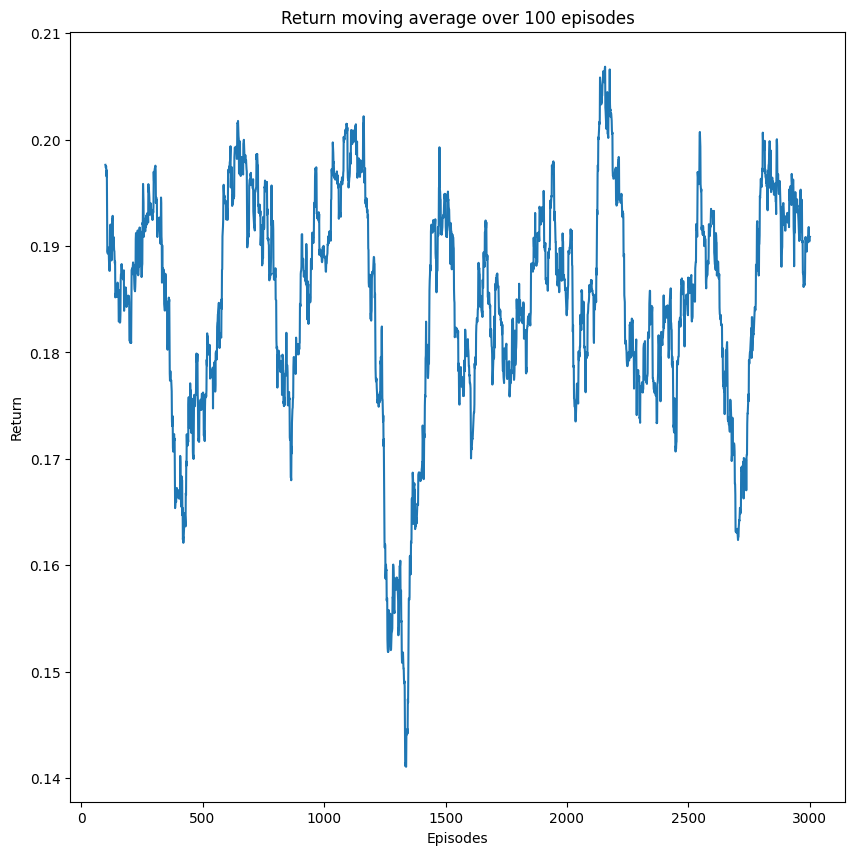

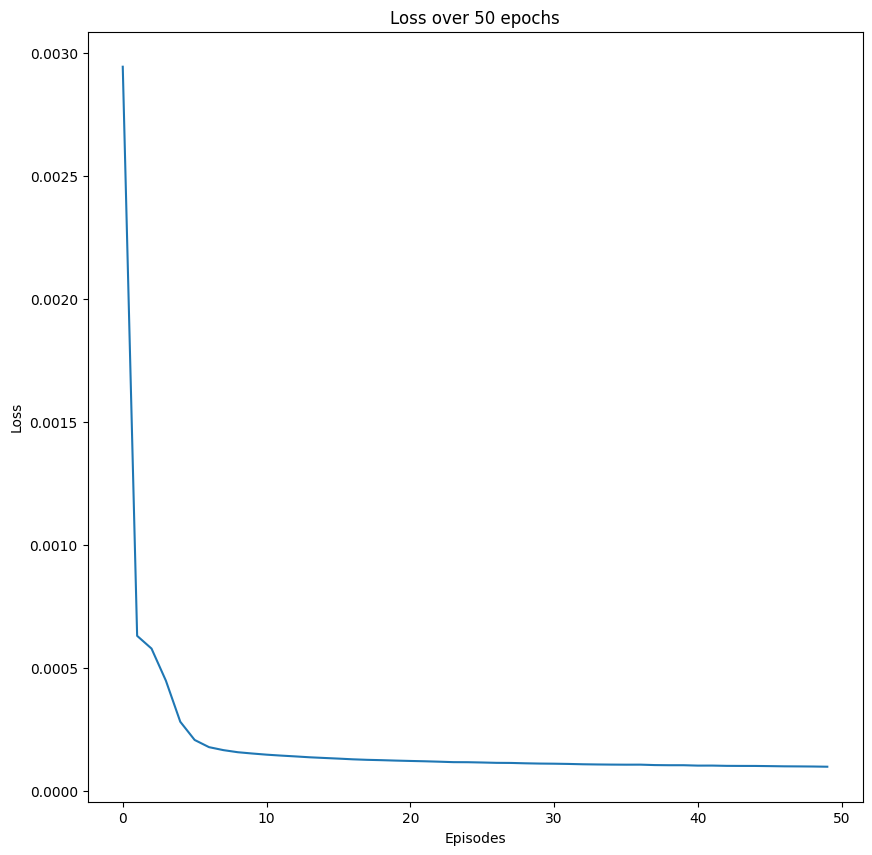

In [8]:
# Save the IL model parameters, buffer state, and keys
il_model_params = il_out['model_params']
reset_key = il_out['reset_key']
policy_key = il_out['policy_key']
buffer_state = il_out['buffer_state']
current_buffer_size = il_out['current_buffer_size']

# Plot the losses and returns
window = 100
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(il_out['returns'])-(window-1))+window, jnp.convolve(il_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss over {} epochs'.format(len(il_out['losses'])))
ax.plot(np.arange(len(il_out['losses'])), il_out['losses'])
plt.show()

Let's test the IL trained agent on 1000 unseen trials.

In [9]:
test_k_trials(1000, 2, env, policy, il_model_params)

Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]

Success rate: 0.029999999329447746
Collision rate: 0.0
Timeout rate: 0.9699999690055847
Average return: 0.009999999776482582
Average time to goal: 15.269999504089355


{'collisions': Array(0, dtype=int32, weak_type=True),
 'returns': Array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.09869146e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.11386308e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.95150299e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.11386308e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00

<h2>Reinforcement Learning</h2>

Initialize the optimizer and the next rollout parameters. We should start from the model parameters compute after IL.

In [10]:
# Initialize RL optimizer
optimizer = optax.sgd(learning_rate=rl_learning_rate, momentum=0.9)

# Initialize RL rollout params
rl_rollout_params = {
    'initial_vnet_params': il_model_params,
    'train_episodes': rl_training_episodes,
    'random_seed': random_seed,
    'model': policy.model,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': current_buffer_size,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_batches': rl_num_batches,
    'epsilon_decay_fn': epsilon_scaling_decay,
    'epsilon_start': epsilon_start,
    'epsilon_end': epsilon_end,
    'decay_rate': epsilon_decay,
    'target_update_interval': target_update_interval,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

Let's start the RL rollout.

In [11]:
rl_out = deep_vnet_rl_rollout(**rl_rollout_params)

Running for 20,000 iterations: 100%|██████████| 20000/20000 [25:59<00:00, 12.83it/s]


Save the final model parameters and plot discounted return and loss over the RL training episodes.

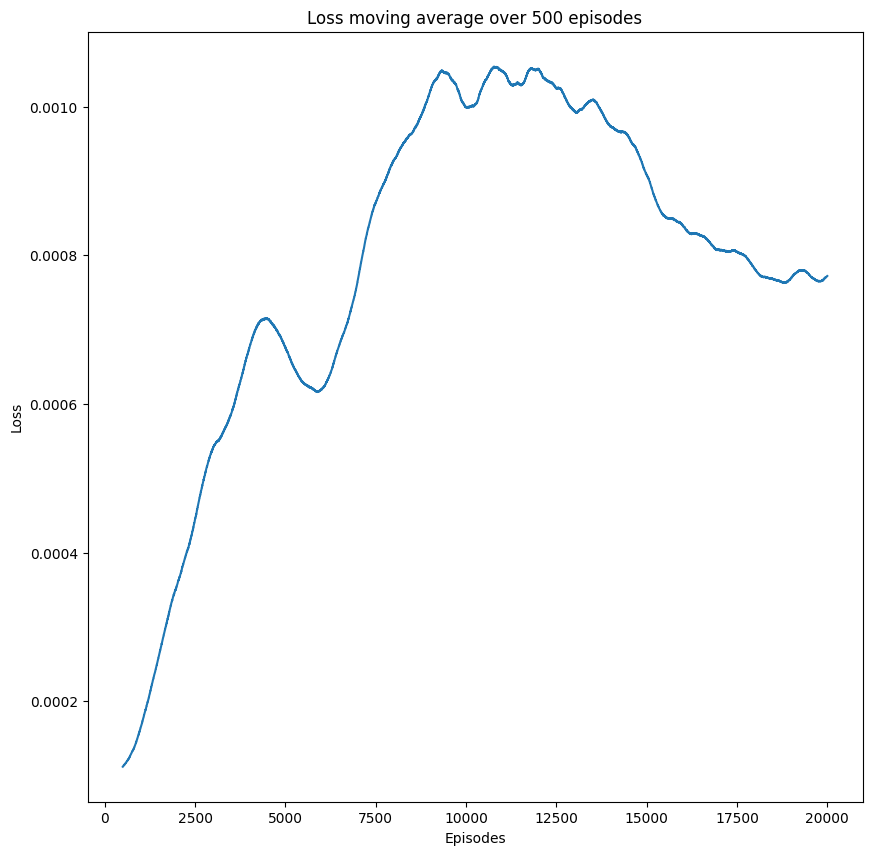

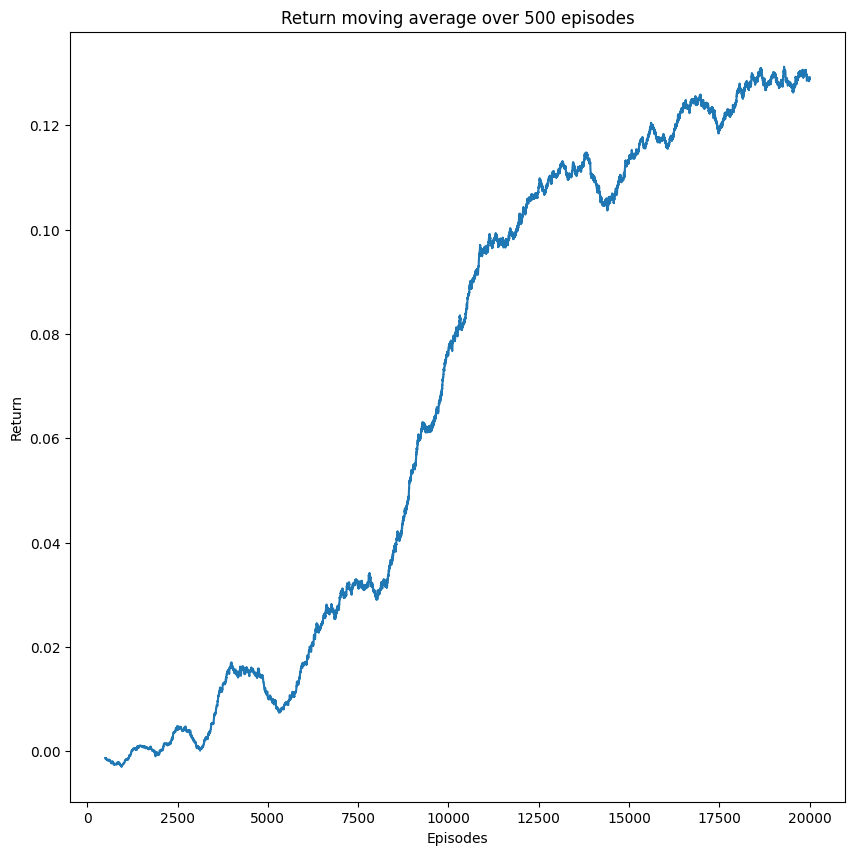

In [12]:
# Save the final model parameters and keys
final_model_params = rl_out['model_params']
reset_key = rl_out['reset_key']
policy_key = rl_out['policy_key']

figure, ax = plt.subplots(figsize=(10,10))
window = 500
ax.plot(np.arange(len(rl_out['losses'])-(window-1))+window, jnp.convolve(rl_out['losses'], jnp.ones(window,), 'valid') / window)
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss moving average over {} episodes'.format(window))
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(rl_out['returns'])-(window-1))+window, jnp.convolve(rl_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()

Let's test the RL trained agent in three environments, with 1, 5 and 10 humans. In all environments the robot is visible.

In [13]:
env_params = {
    'robot_radius': 0.3,
    'n_humans': 1,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': 'circular_crossing',
    'humans_policy': 'hsfm',
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env = SocialNav(**env_params)
env5_params = {
    'robot_radius': 0.3,
    'n_humans': 5,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': 'circular_crossing',
    'humans_policy': 'hsfm',
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env5 = SocialNav(**env5_params)
env10_params = {
    'robot_radius': 0.3,
    'n_humans': 10,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': 'circular_crossing',
    'humans_policy': 'hsfm',
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env10 = SocialNav(**env10_params)
test_k_trials(1000, 3, env, policy, final_model_params)
test_k_trials(1000, 3, env5, policy, final_model_params)
test_k_trials(1000, 3, env10, policy, final_model_params)

Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:08<00:00, 124.48it/s]


Success rate: 1.0
Collision rate: 0.0
Timeout rate: 0.0
Average return: 0.17000000178813934
Average time to goal: 17.43000030517578
Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:58<00:00, 17.17it/s]


Success rate: 0.9699999690055847
Collision rate: 0.009999999776482582
Timeout rate: 0.019999999552965164
Average return: 0.09999999403953552
Average time to goal: 23.149999618530273
Executing 1000 tests with 10 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]

Success rate: 0.8499999642372131
Collision rate: 0.07999999821186066
Timeout rate: 0.07000000029802322
Average return: 0.04999999701976776
Average time to goal: 28.439998626708984


{'collisions': Array(83, dtype=int32, weak_type=True),
 'returns': Array([-5.16554760e-03,  4.02157530e-02,  7.43357465e-02,  1.80388130e-02,
         8.14153329e-02,  7.27617973e-03,  7.25910068e-02,  1.42569374e-02,
        -3.57981329e-03,  4.79513258e-02, -3.26174721e-02,  9.81019363e-02,
         8.85501690e-03,  4.45127189e-02,  1.35085106e-01,  1.11497849e-01,
         9.67247188e-02,  4.23911251e-02,  7.86488429e-02,  1.49479229e-02,
         8.81647244e-02, -1.83570141e-04,  1.53329074e-02,  8.18953663e-02,
         7.39663914e-02,  3.17279361e-02,  1.36586428e-01,  1.75146535e-02,
         1.03174247e-01,  5.09742163e-02,  7.47742038e-03,  4.24903929e-02,
         2.99768206e-02, -1.19529599e-02,  8.57965127e-02,  2.55754068e-02,
         1.03803910e-01,  2.08279677e-03,  8.18953663e-02,  1.93702858e-02,
         2.80965660e-02,  1.86082926e-02,  6.03616564e-03,  1.03803910e-01,
         1.09418929e-01,  1.07290424e-01, -3.23061459e-02,  8.63252953e-02,
         1.78870093e-0

Simulate some episodes using the trained agent.

Episode 0 ended - Execution time 6.02 seconds - Plotting trajectory...


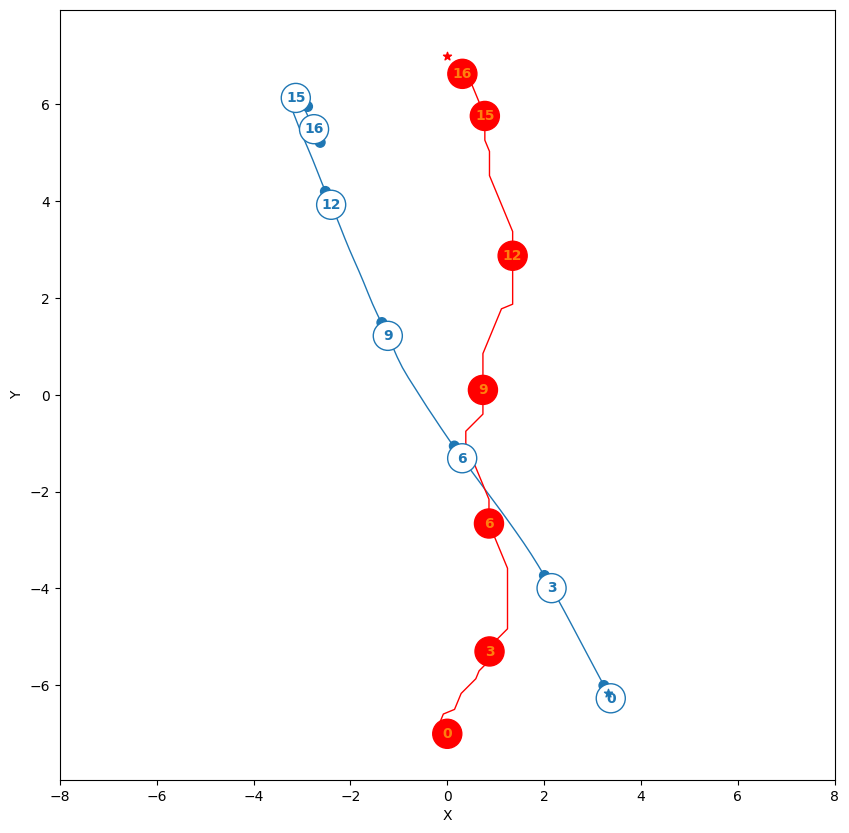

Episode 1 ended - Execution time 0.05 seconds - Plotting trajectory...


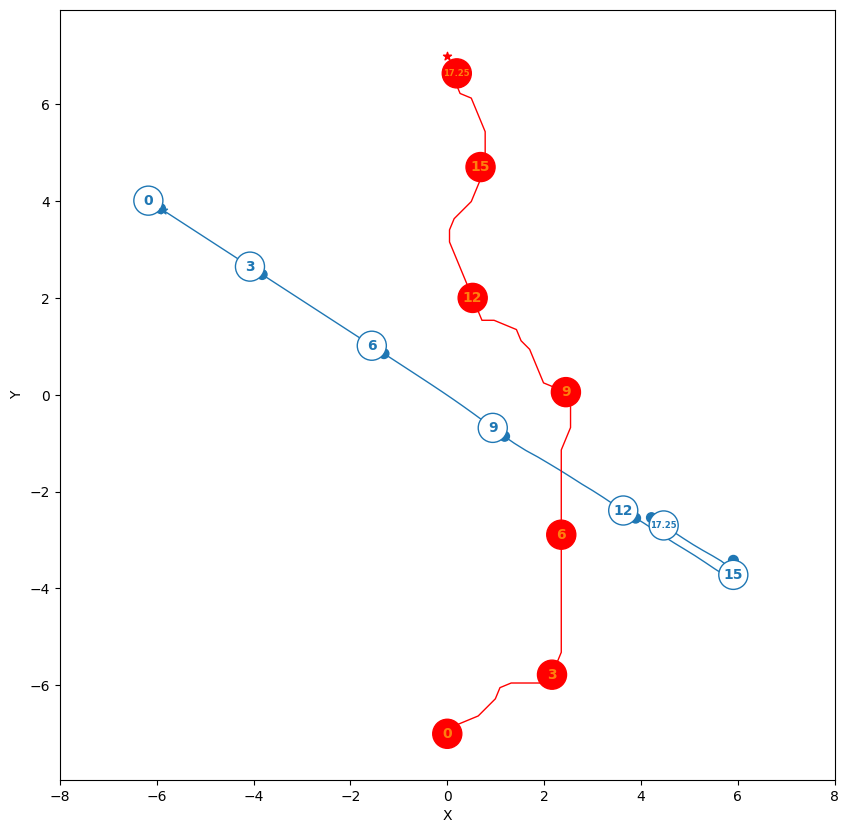

Episode 2 ended - Execution time 0.05 seconds - Plotting trajectory...


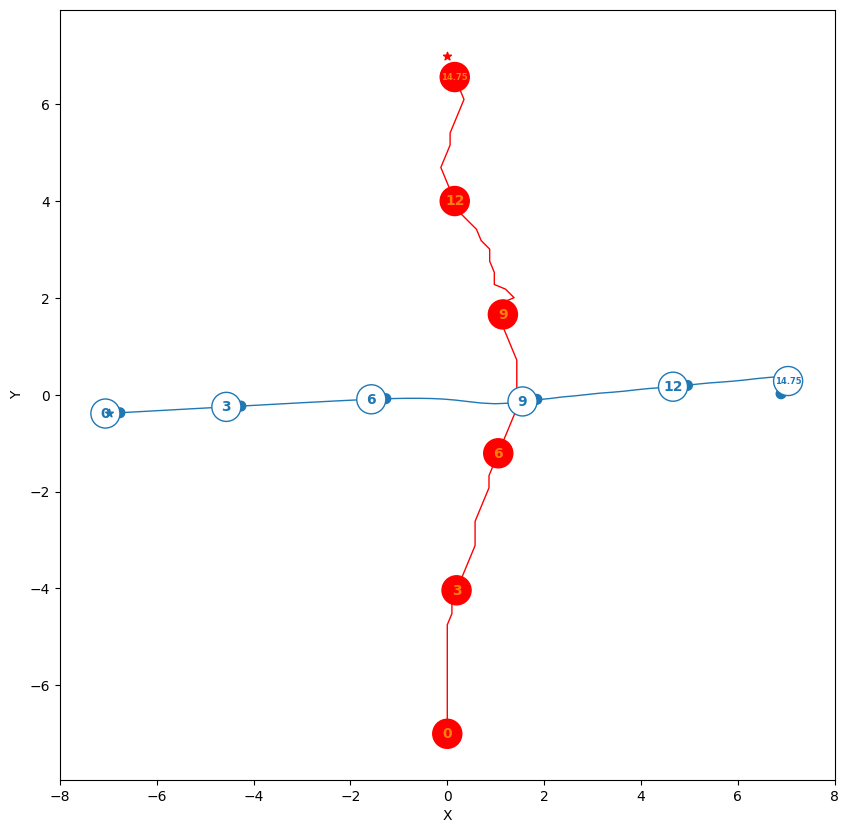

Episode 3 ended - Execution time 0.04 seconds - Plotting trajectory...


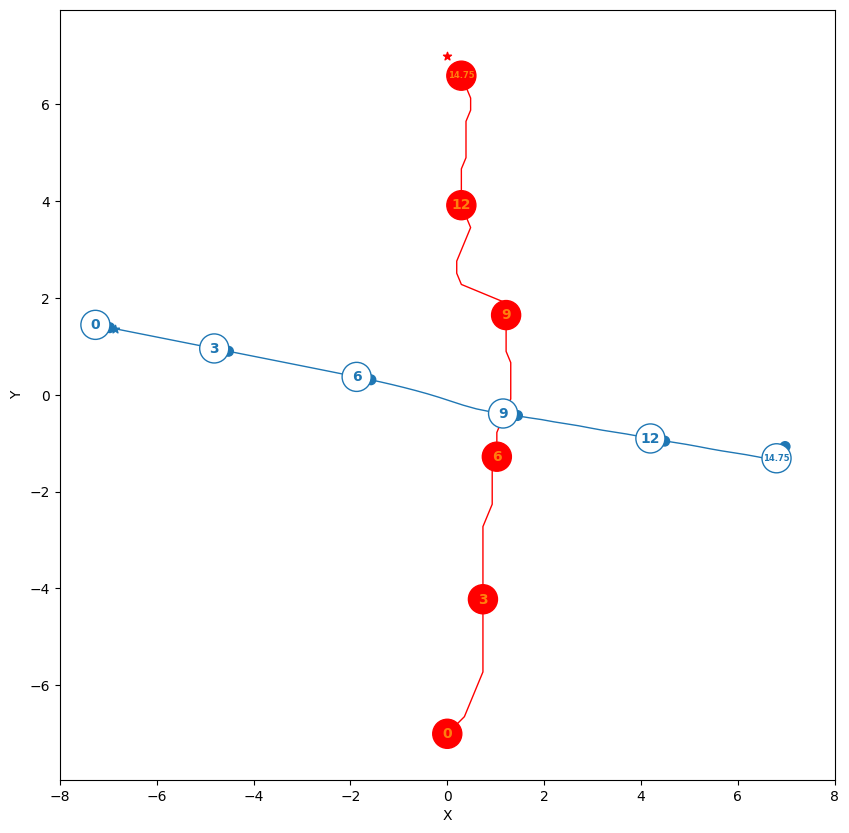

Episode 4 ended - Execution time 0.07 seconds - Plotting trajectory...


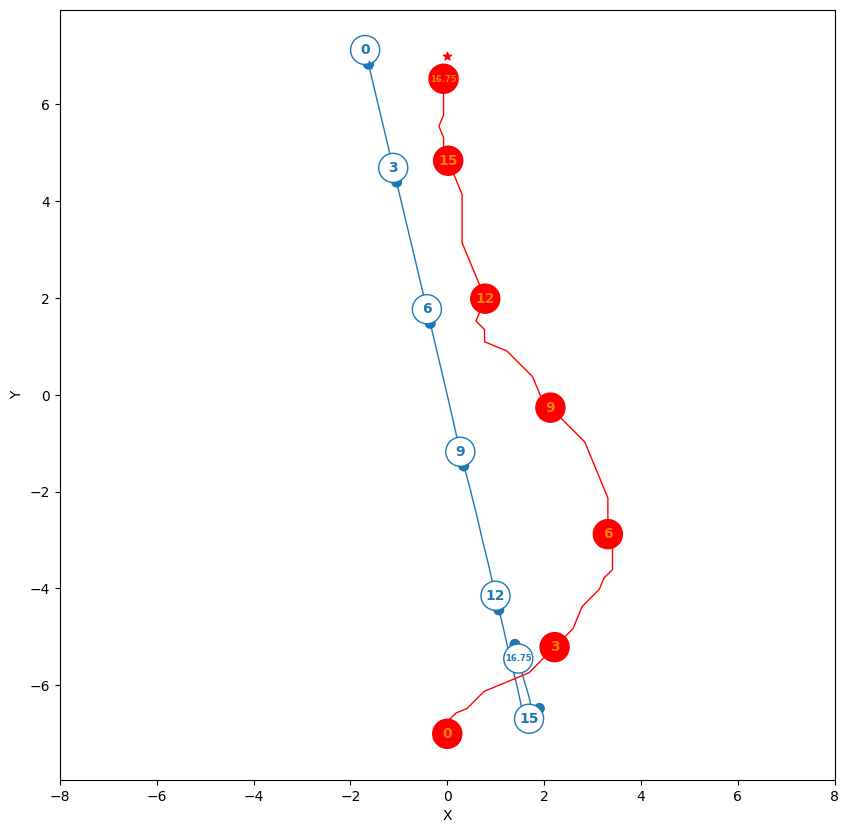

Average time per episode: 1.25 seconds
Total time for 5 episodes: 6.23 seconds


In [14]:
n_episodes = 5
env_params["n_humans"] = 1
env = SocialNav(**env_params)
# Simulate some episodes
episode_simulation_times = np.empty((n_episodes,))
for i in range(n_episodes):
    done = False
    episode_start_time = time.time()
    state, reset_key, obs, info = env.reset(reset_key)
    all_states = np.array([state])
    while not done:
        # action = jnp.array([0.,1.]) # Move north
        action, policy_key, _ = policy.act(policy_key, obs, info, final_model_params, 0.)
        state, obs, info, reward, done = env.step(state,info,action) 
        all_states = np.vstack((all_states, [state]))
    episode_simulation_times[i] = round(time.time() - episode_start_time,2)
    all_states = device_get(all_states) # Transfer data from GPU to CPU for plotting
    print(f"Episode {i} ended - Execution time {episode_simulation_times[i]} seconds - Plotting trajectory...")
    ## Plot episode trajectory
    figure, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    plot_trajectory(ax, all_states, info['humans_goal'], info['robot_goal'])
    for k in range(0,len(all_states),int(3/env_params['robot_dt'])):
        plot_state(ax, k*env_params['robot_dt'], all_states[k], env_params['humans_policy'], env_params['scenario'], info["humans_parameters"][:,0], env.robot_radius)
    # plot last state
    plot_state(ax, (len(all_states)-1)*env_params['robot_dt'], all_states[len(all_states)-1], env_params['humans_policy'], env_params['scenario'], info["humans_parameters"][:,0], env.robot_radius)
    plt.show()
# Print simulation times
print(f"Average time per episode: {round(np.mean(episode_simulation_times),2)} seconds")
print(f"Total time for {n_episodes} episodes: {round(np.sum(episode_simulation_times),2)} seconds")